# アミノ酸配列のグラフ表示画像のVision Transformerによるタンパク質ファミリー分類（5分割交差検証）
- グラデーション適用
- クラスごとに分ける `StratifiedKFold` を採用
- 複数クラスに属するアミノ酸配列を除外
- ベースモデル：`google/vit-base-patch16-224-in21k`
- ハイパーパラメータ
    - バッチサイズ：$16$
    - エポック数：$20$
    - 学習率：$5 \times 10^{-5}$

## 1. ライブラリのインポート

In [7]:
from torch.utils.data import Dataset, Subset
from PIL import Image
import os
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTImageProcessorFast, ViTForImageClassification, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import evaluate

label2id = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
id2label = {v: k for k, v in label2id.items()}

MODEL_NAME = "google/vit-base-patch16-224-in21k"
BATCH_SIZE = 16
EPOCHS = 20
LR = 5e-5
# WEIGHT_DECAY = 1e-4

## 1. 画像とラベルの対応を取る `Dataset` を作成

In [8]:
class GPCRImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=["num", "label", "accession"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['num']}.png")
        image = Image.open(img_path).convert("RGB")
        label = label2id[row["label"]]

        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image, "label": label}

## 2. 画像前処理（ViT用）

In [9]:
processor = ViTImageProcessorFast.from_pretrained(MODEL_NAME)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

## 3. `Trainer` を使って学習

In [10]:
accuracy = evaluate.load("accuracy")
dataset = GPCRImageDataset("../../../data/gpcr-dataset-exclusion-duplicate.csv", "../../../graphs/exclusion-duplicate", transform=transform)

# StratifiedKFoldはラベル情報を使う
labels = dataset.data["label"].values
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

[Fold 1 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_60176\880580438.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.219079,0.940250,0.556693,0.514663,0.532803
2,0.315900,0.135801,0.961917,0.557957,0.559901,0.558898
3,0.121400,0.184511,0.950755,0.553700,0.547341,0.549863
4,0.069600,0.125817,0.968483,0.766697,0.616056,0.646258
5,0.069600,0.153761,0.967170,0.686898,0.768764,0.720636
6,0.029000,0.132134,0.975049,0.882024,0.873413,0.877253
7,0.013800,0.176947,0.967170,0.774296,0.759334,0.766528
8,0.010300,0.160318,0.971110,0.874916,0.860509,0.867391
9,0.010300,0.154406,0.971110,0.767736,0.765248,0.766465
10,0.002000,0.160693,0.971766,0.769832,0.766105,0.767901


Accuracy: 0.9737 | Precision: 0.7726 | Recall: 0.7656 | F1: 0.7689
              precision    recall  f1-score      support
A              0.987572  0.985687  0.986628  1048.000000
B              0.926829  0.873563  0.899408    87.000000
C              0.948718  0.968586  0.958549   382.000000
D              0.000000  0.000000  0.000000     2.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.973736  0.973736  0.973736     0.973736
macro avg      0.772624  0.765567  0.768917  1523.000000
weighted avg   0.973092  0.973736  0.973343  1523.000000


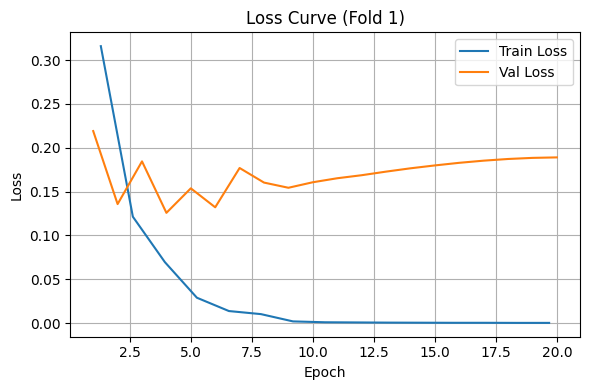

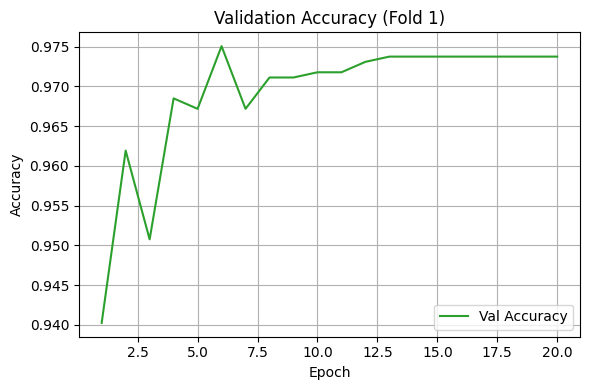

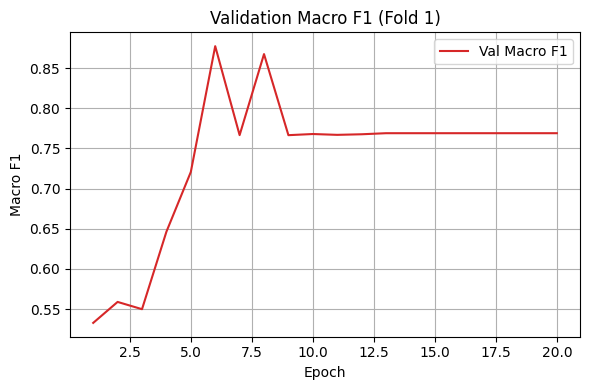

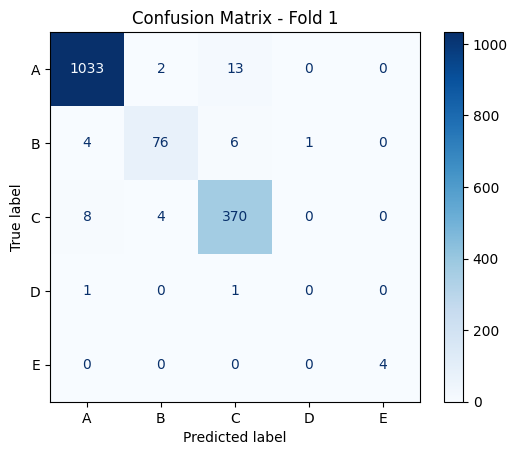

[Fold 2 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_60176\880580438.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.176748,0.948785,0.565338,0.546952,0.555297
2,0.316100,0.146229,0.963230,0.576024,0.561688,0.567823
3,0.110300,0.121625,0.967827,0.568666,0.567128,0.567362
4,0.060400,0.165204,0.959291,0.565060,0.533805,0.546034
5,0.060400,0.129578,0.973736,0.653973,0.775962,0.689244
6,0.024800,0.177554,0.962574,0.678454,0.705603,0.690270
7,0.018100,0.142781,0.974393,0.888364,0.974915,0.925817
8,0.008900,0.159123,0.969796,0.809765,0.914673,0.839196
9,0.008900,0.157129,0.971766,0.770634,0.975261,0.838299
10,0.002200,0.157020,0.974393,0.841421,0.974583,0.889054


Accuracy: 0.9750 | Precision: 0.8618 | Recall: 0.9765 | F1: 0.9069
              precision    recall  f1-score      support
A              0.983779  0.984718  0.984248  1047.000000
B              0.964706  0.942529  0.953488    87.000000
C              0.960526  0.955497  0.958005   382.000000
D              0.600000  1.000000  0.750000     3.000000
E              0.800000  1.000000  0.888889     4.000000
accuracy       0.975049  0.975049  0.975049     0.975049
macro avg      0.861802  0.976549  0.906926  1523.000000
weighted avg   0.975618  0.975049  0.975197  1523.000000


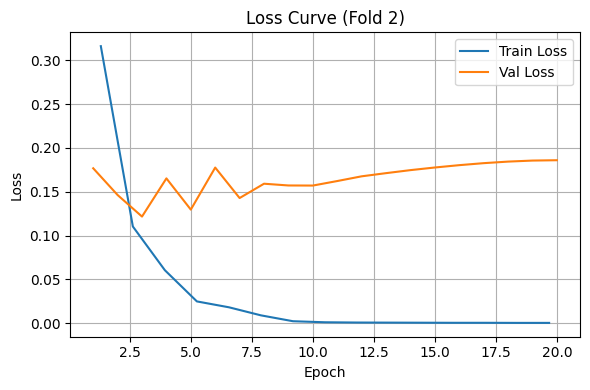

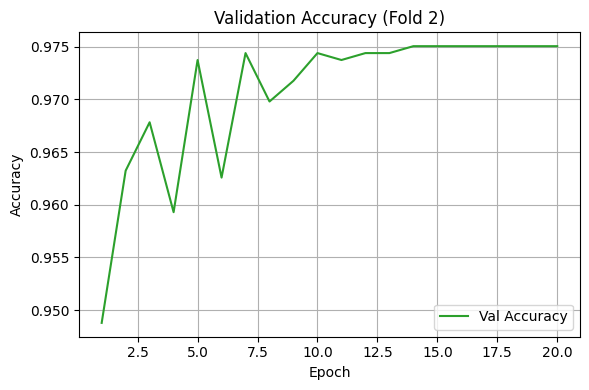

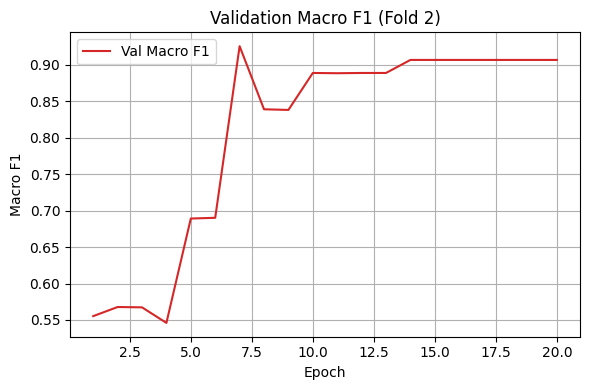

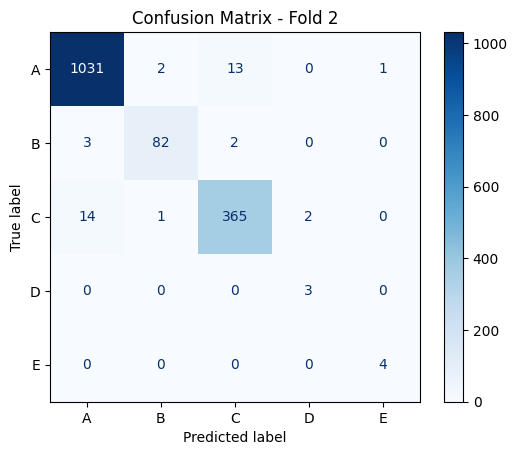

[Fold 3 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_60176\880580438.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.159814,0.961892,0.557713,0.556567,0.556953
2,0.303500,0.164896,0.954665,0.743060,0.635031,0.654929
3,0.093600,0.112236,0.971091,0.969960,0.699294,0.767929
4,0.039600,0.134993,0.968463,0.864549,0.695311,0.743189
5,0.039600,0.136679,0.970434,0.848662,0.763915,0.766251
6,0.022900,0.139227,0.974376,0.980229,0.698361,0.771874
7,0.006600,0.171942,0.966491,0.865545,0.698064,0.744491
8,0.006200,0.165166,0.972405,0.983075,0.691132,0.769013
9,0.006200,0.182017,0.971091,0.981697,0.757005,0.828343
10,0.005300,0.178694,0.972405,0.980469,0.760160,0.829630


Accuracy: 0.9724 | Precision: 0.9805 | Recall: 0.7602 | F1: 0.8296
              precision    recall  f1-score      support
A              0.975518  0.989494  0.982456  1047.000000
B              0.961039  0.850575  0.902439    87.000000
C              0.965789  0.960733  0.963255   382.000000
D              1.000000  0.333333  0.500000     3.000000
E              1.000000  0.666667  0.800000     3.000000
accuracy       0.972405  0.972405  0.972405     0.972405
macro avg      0.980469  0.760160  0.829630  1522.000000
weighted avg   0.972345  0.972405  0.971752  1522.000000


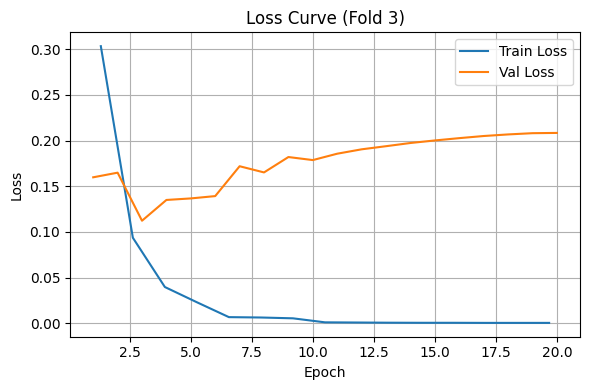

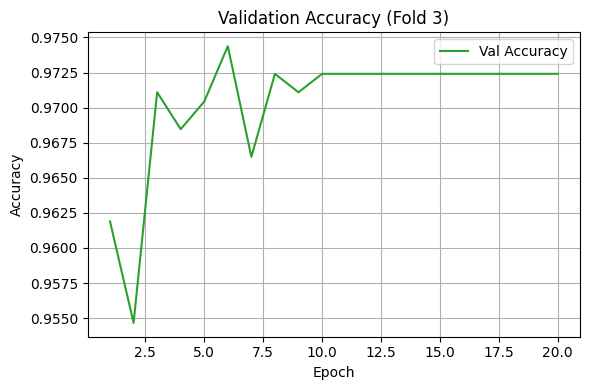

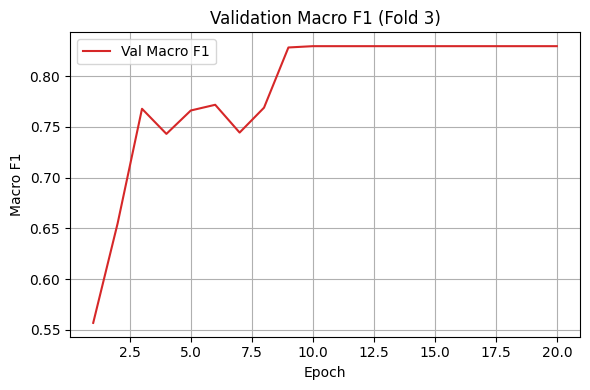

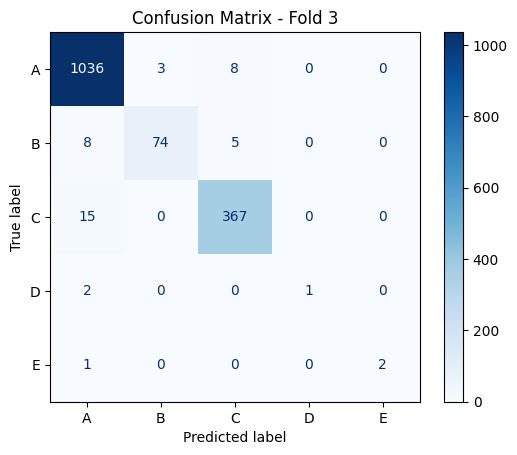

[Fold 4 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_60176\880580438.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.249064,0.932983,0.550680,0.505903,0.524193
2,0.307900,0.149045,0.953351,0.538192,0.549541,0.543414
3,0.110000,0.147848,0.967148,0.762619,0.754749,0.758299
4,0.052500,0.201482,0.959921,0.770869,0.723358,0.740003
5,0.052500,0.158536,0.967148,0.913639,0.823665,0.831452
6,0.020600,0.174697,0.969777,0.963895,0.762389,0.822784
7,0.006600,0.178134,0.967148,0.860797,0.886590,0.870894
8,0.008800,0.207701,0.963863,0.865946,0.814279,0.835475
9,0.008800,0.191236,0.968463,0.857654,0.839912,0.845094
10,0.002500,0.190598,0.968463,0.828326,0.768556,0.791716


Accuracy: 0.9698 | Precision: 0.8645 | Recall: 0.7657 | F1: 0.8051
              precision    recall  f1-score      support
A              0.988473  0.982808  0.985632  1047.000000
B              0.895349  0.885057  0.890173    87.000000
C              0.938619  0.960733  0.949547   382.000000
D              0.500000  0.333333  0.400000     3.000000
E              1.000000  0.666667  0.800000     3.000000
accuracy       0.969777  0.969777  0.969777     0.969777
macro avg      0.864488  0.765720  0.805071  1522.000000
weighted avg   0.969697  0.969777  0.969599  1522.000000


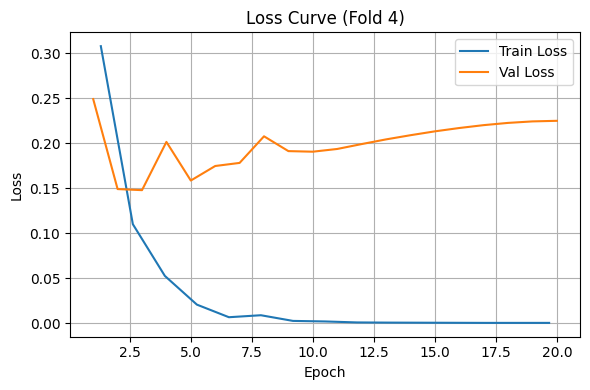

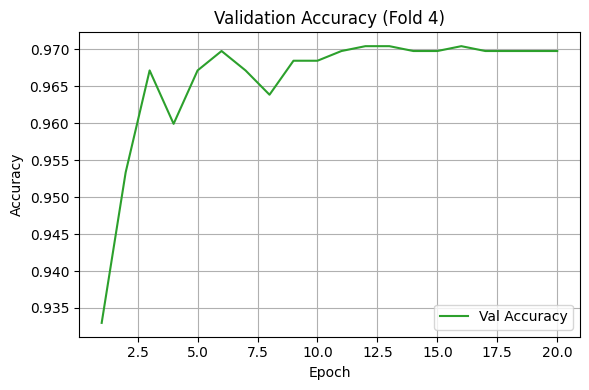

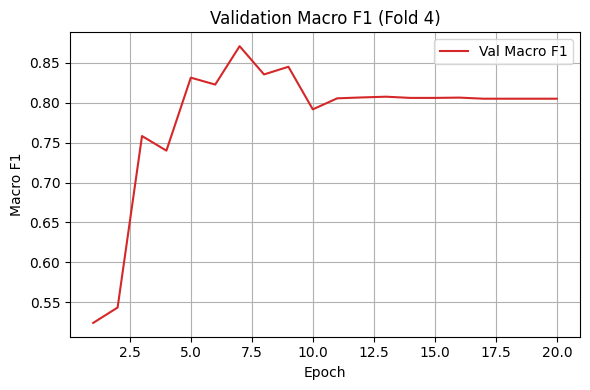

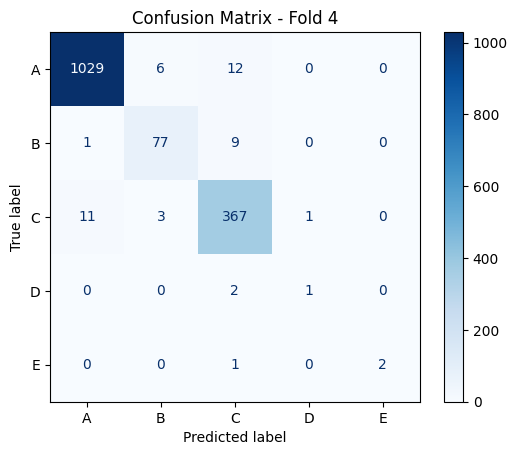

[Fold 5 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_60176\880580438.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.288029,0.921813,0.557280,0.513651,0.532496
2,0.302800,0.113351,0.969777,0.579604,0.556971,0.566491
3,0.117200,0.080554,0.973719,0.718202,0.777992,0.745121
4,0.048500,0.139851,0.965834,0.766351,0.760060,0.763109
5,0.048500,0.120911,0.975033,0.897747,0.875517,0.863139
6,0.016300,0.101823,0.977004,0.937768,0.869879,0.884832
7,0.010800,0.099465,0.982260,0.803562,0.867744,0.823111
8,0.004000,0.090675,0.981603,0.813699,0.874654,0.838380
9,0.004000,0.089907,0.983574,0.814717,0.879776,0.841585
10,0.001200,0.092098,0.984231,0.848064,0.880299,0.861852


Accuracy: 0.9836 | Precision: 0.8476 | Recall: 0.8801 | F1: 0.8615
              precision    recall  f1-score      support
A              0.990449  0.990449  0.990449  1047.000000
B              0.975904  0.931034  0.952941    87.000000
C              0.971429  0.979058  0.975228   382.000000
D              0.500000  0.500000  0.500000     2.000000
E              0.800000  1.000000  0.888889     4.000000
accuracy       0.983574  0.983574  0.983574     0.983574
macro avg      0.847556  0.880108  0.861501  1522.000000
weighted avg   0.983699  0.983574  0.983573  1522.000000


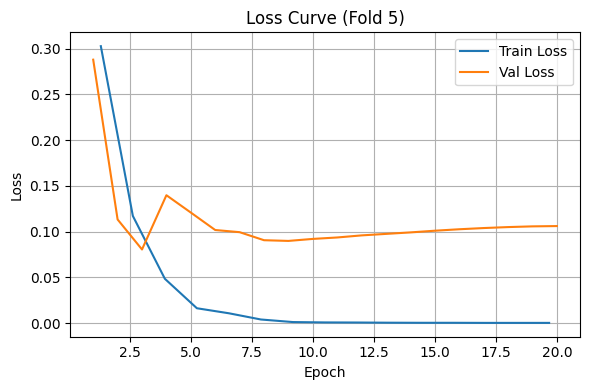

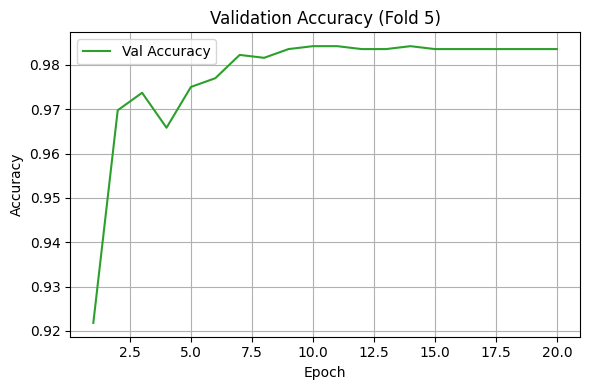

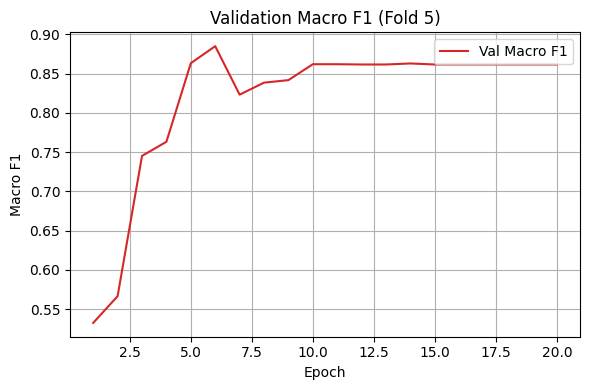

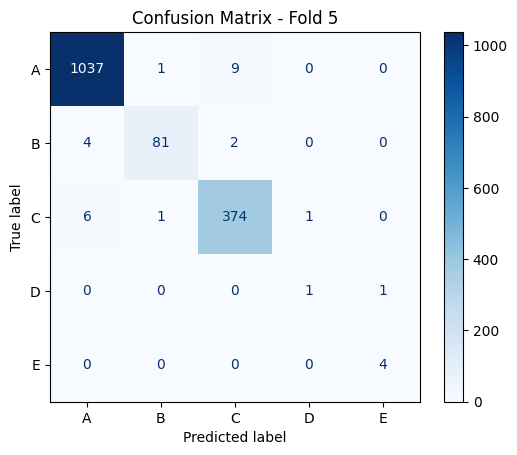

In [11]:
all_accs, all_pres, all_recs, all_f1s = [], [], [], []
all_class_f1s, all_conf_matrices = [], []
all_val_losses, all_val_accs, all_val_f1s = [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\033[34m[Fold {fold+1} / 5]\033[0m")

    # Subset 作成
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # ======================
    # 4. モデル初期化
    # ======================
    model = ViTForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=5,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"../models/amino-classification-transformer-vit-google-stratified-kfold/batch-{BATCH_SIZE}-epoch-{EPOCHS}-lr-{LR}/{fold+1}",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=EPOCHS,
        logging_dir="./logs",
        report_to="none",
        learning_rate=LR,
        load_best_model_at_end=False
    )

    # ======================
    # 5. 評価指標
    # ======================
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
        f1 = f1_score(labels, preds, average="macro")
        pre = precision_score(labels, preds, average="macro", zero_division=0)
        rec = recall_score(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "precision": pre, "recall": rec, "f1": f1}

    # ======================
    # 6. Trainer実行
    # ======================
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # ==== ログから学習曲線抽出 ====
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.dropna(subset=["epoch"])
    train_loss = log_history[log_history["loss"].notna()][["epoch", "loss"]]
    eval_loss = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]

    all_val_losses.append(eval_loss["eval_loss"].values)
    all_val_accs.append(eval_loss["eval_accuracy"].values)
    all_val_f1s.append(eval_loss["eval_f1"].values)

    # ======================
    # 7. 推論と評価
    # ======================
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    acc = accuracy.compute(predictions=y_pred, references=y_true)["accuracy"]
    pre = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(label2id.values()))

    report = classification_report(y_true, y_pred, target_names=list(label2id.keys()), output_dict=True)
    class_f1 = [report[c]["f1-score"] for c in list(label2id.keys())]

    # ==== 保存 ====
    all_accs.append(acc)
    all_pres.append(pre)
    all_recs.append(rec)
    all_f1s.append(f1)
    all_class_f1s.append(class_f1)
    all_conf_matrices.append(cm)

    # ==== 表示 ====
    print(f"\033[91mAccuracy: {acc:.4f}\033[0m | "
          f"\033[92mPrecision: {pre:.4f}\033[0m | "
          f"\033[93mRecall: {rec:.4f}\033[0m | "
          f"\033[94mF1: {f1:.4f}\033[0m")
    print(pd.DataFrame(report).T)

    # ==== foldごとの学習曲線を可視化 ====
    # --- Loss 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", color="C0")
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Val Loss", color="C1")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Accuracy 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_accuracy"], label="Val Accuracy", color="C2")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Macro F1 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_f1"], label="Val Macro F1", color="C3")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title(f"Validation Macro F1 (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 混同行列を可視化
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

## 4. 平均可視化

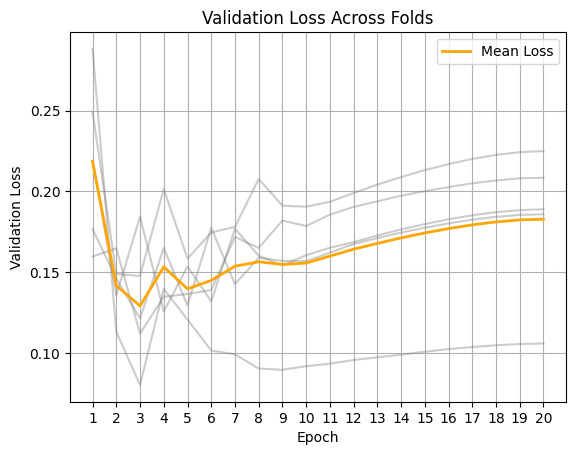

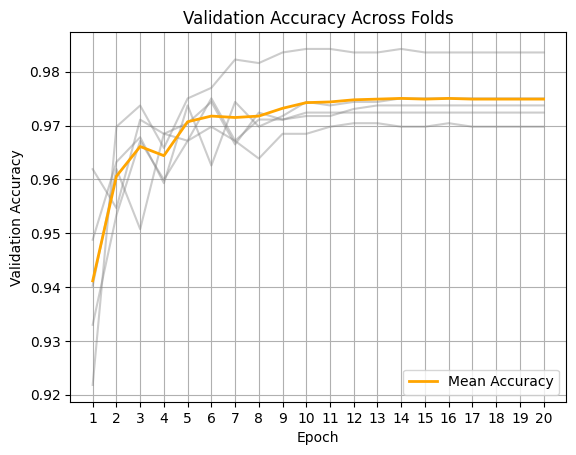

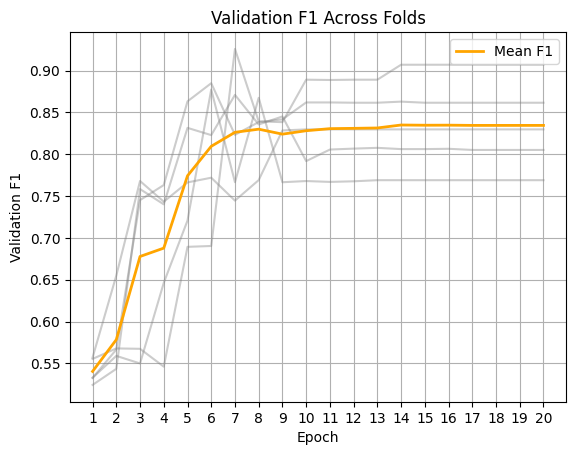

In [12]:
epochs = np.arange(1, EPOCHS + 1)

def interp_to_epochs(arr):
    arr = np.asarray(arr)
    orig_x = np.arange(1, len(arr) + 1)

    if len(arr) == 1:
        return np.full_like(epochs, arr[0], dtype=float)

    return np.interp(epochs, orig_x, arr)

def plot_mean_curves(all_vals, y_label, title, metric_name):
    interp_vals = []

    for v in all_vals:
        v_interp = interp_to_epochs(v)
        interp_vals.append(v_interp)
        plt.plot(epochs, v_interp, color="gray", alpha=0.4)

    interp_vals = np.vstack(interp_vals)
    mean_vals = interp_vals.mean(axis=0)

    plt.plot(epochs, mean_vals, color="orange", linewidth=2, label=f"Mean {metric_name}")
    plt.xlabel("Epoch"); plt.ylabel(y_label); plt.title(title)
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)
    plt.show()

plot_mean_curves(all_val_losses, "Validation Loss", "Validation Loss Across Folds", "Loss")
plot_mean_curves(all_val_accs, "Validation Accuracy", "Validation Accuracy Across Folds", "Accuracy")
plot_mean_curves(all_val_f1s, "Validation F1", "Validation F1 Across Folds", "F1")

## 5. 総合評価


===== Average Across 5 Folds =====
Accuracy : 0.9749
Precision: 0.8654
Recall   : 0.8296
F1       : 0.8344

Per-Class F1 (Macro Average):
  A: 0.9859
  B: 0.9197
  C: 0.9609
  D: 0.4300
  E: 0.8756


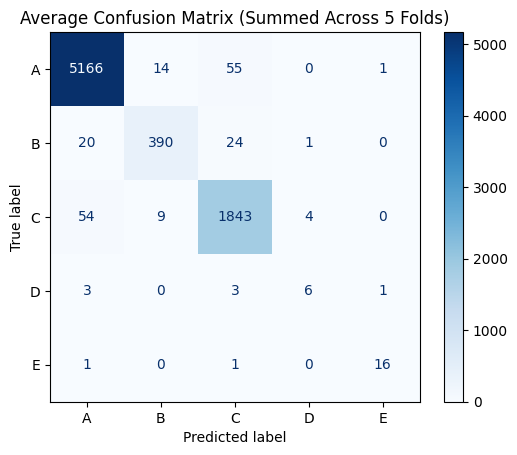

In [13]:
mean_acc = np.mean(all_accs)
mean_pre = np.mean(all_pres)
mean_rec = np.mean(all_recs)
mean_f1 = np.mean(all_f1s)
mean_class_f1 = np.mean(np.array(all_class_f1s), axis=0)

print("\n\033[36m===== Average Across 5 Folds =====\033[0m")
print(f"Accuracy : {mean_acc:.4f}")
print(f"Precision: {mean_pre:.4f}")
print(f"Recall   : {mean_rec:.4f}")
print(f"F1       : {mean_f1:.4f}\n")

print("Per-Class F1 (Macro Average):")
for cls, score in zip(label2id.keys(), mean_class_f1):
    print(f"  {cls}: {score:.4f}")

# ==== 混同行列平均表示 ====
mean_cm = np.sum(all_conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues")
plt.title("Average Confusion Matrix (Summed Across 5 Folds)")
plt.show()